In [2]:
# Import libraries for data handling
import pandas as pd
from google.colab import drive

# Import libraries for text preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re, string

# Import libraries for vectorization and modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Import libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Import libraries for neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical

# Import libraries for word frequency analysis and visualization
from collections import Counter
import matplotlib.pyplot as plt

# Download required NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')  # Added to fix the LookupError
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
# Define DataLoader class for loading the dataset
class DataLoader:
    def __init__(self, train_path, test_path):
        """
        Initialize DataLoader with paths to train and test CSV files.

        Args:
            train_path (str): Path to the train CSV file
            test_path (str): Path to the test CSV file
        """
        self.train_path = train_path
        self.test_path = test_path
        self.data = None

    def load_data(self):
        """
        Load the AG News dataset from Google Drive (train and test) and return as DataFrame.

        Returns:
            pandas.DataFrame: Combined dataset with a 'split' column
        """
        # Mount Google Drive
        drive.mount('/content/drive', force_remount=True)

        # Load train and test datasets
        train_data = pd.read_csv(self.train_path)
        test_data = pd.read_csv(self.test_path)

        # Add 'split' column to indicate train or test
        train_data['split'] = 'train'
        test_data['split'] = 'test'

        # Combine datasets
        self.data = pd.concat([train_data, test_data], ignore_index=True)

        # Combine 'Title' and 'Description' into a single 'combined_text' column
        self.data['combined_text'] = self.data['Title'] + ' ' + self.data['Description']

        # Display sample of the data
        print("Sample of the combined dataset:")
        print(self.data.head())

        # Display dataset info
        print("\nDataset Info:")
        print(self.data.info())

        return self.data

# Instantiate DataLoader and load the dataset
train_path = '/content/drive/My Drive/Elevvo_Pathway/Task_2/train.csv'
test_path = '/content/drive/My Drive/Elevvo_Pathway/Task_2/test.csv'
data_loader = DataLoader(train_path, test_path)
data = data_loader.load_data()

Mounted at /content/drive
Sample of the combined dataset:
   Class Index                                              Title  \
0            3  Wall St. Bears Claw Back Into the Black (Reuters)   
1            3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2            3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3            3  Iraq Halts Oil Exports from Main Southern Pipe...   
4            3  Oil prices soar to all-time record, posing new...   

                                         Description  split  \
0  Reuters - Short-sellers, Wall Street's dwindli...  train   
1  Reuters - Private investment firm Carlyle Grou...  train   
2  Reuters - Soaring crude prices plus worries\ab...  train   
3  Reuters - Authorities have halted oil export\f...  train   
4  AFP - Tearaway world oil prices, toppling reco...  train   

                                       combined_text  
0  Wall St. Bears Claw Back Into the Black (Reute...  
1  Carlyle Looks Toward Commercial Aer

In [4]:
# Define TextPreprocessor class for cleaning text data
class TextPreprocessor:
    def __init__(self):
        """
        Initialize TextPreprocessor with NLTK lemmatizer and stop words.
        """
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def clean_text(self, text):
        """
        Clean a single text string by applying preprocessing steps.

        Args:
            text (str): Input text to clean

        Returns:
            str: Cleaned text
        """
        # Convert to lowercase
        text = text.lower()
        # Remove punctuation and numbers
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        # Tokenize text
        words = word_tokenize(text)
        # Remove stop words and lemmatize
        words = [self.lemmatizer.lemmatize(word) for word in words if word not in self.stop_words]
        # Join words back into a string
        return ' '.join(words)

    def preprocess(self, texts):
        """
        Preprocess a list of texts.

        Args:
            texts (list): List of text strings to preprocess

        Returns:
            list: List of cleaned text strings
        """
        return [self.clean_text(text) for text in texts]

# Instantiate TextPreprocessor
preprocessor = TextPreprocessor()

# Apply preprocessing to the 'combined_text' column and add a new column 'processed_text'
data['processed_text'] = preprocessor.preprocess(data['combined_text'])

# Display sample of the dataset with the new column
print("Sample of the dataset with processed text:")
print(data[['combined_text', 'processed_text', 'Class Index', 'split']].head())

Sample of the dataset with processed text:
                                       combined_text  \
0  Wall St. Bears Claw Back Into the Black (Reute...   
1  Carlyle Looks Toward Commercial Aerospace (Reu...   
2  Oil and Economy Cloud Stocks' Outlook (Reuters...   
3  Iraq Halts Oil Exports from Main Southern Pipe...   
4  Oil prices soar to all-time record, posing new...   

                                      processed_text  Class Index  split  
0  wall st bear claw back black reuters reuters s...            3  train  
1  carlyle look toward commercial aerospace reute...            3  train  
2  oil economy cloud stock outlook reuters reuter...            3  train  
3  iraq halt oil export main southern pipeline re...            3  train  
4  oil price soar alltime record posing new menac...            3  train  


In [5]:
# Define NewsVectorizer class for converting text to TF-IDF
class NewsVectorizer:
    def __init__(self):
        """
        Initialize NewsVectorizer with TF-IDF vectorizer.
        """
        self.vectorizer = TfidfVectorizer(max_features=5000)
        self.X = None

    def vectorize(self, texts):
        """
        Convert a list of texts to TF-IDF features.

        Args:
            texts (list): List of preprocessed texts

        Returns:
            scipy.sparse.csr_matrix: TF-IDF matrix
        """
        self.X = self.vectorizer.fit_transform(texts)
        return self.X

# Instantiate NewsVectorizer
vectorizer = NewsVectorizer()

# Vectorize the processed text
X = vectorizer.vectorize(data['processed_text'])

# Display the shape of the TF-IDF matrix
print("Shape of TF-IDF matrix:", X.shape)

Shape of TF-IDF matrix: (127600, 5000)


In [15]:
# Define NewsClassifier class for training and evaluating models
class NewsClassifier:
    def __init__(self, X, y):
        """
        Initialize NewsClassifier with features and labels.

        Args:
            X (scipy.sparse.csr_matrix): TF-IDF matrix
            y (list): List of category labels
        """
        self.X = X
        self.y = y
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.models = {
            'Logistic Regression': LogisticRegression(max_iter=1000, multi_class='ovr'),
            'Random Forest': RandomForestClassifier(),
            'SVM': SVC(kernel='linear', decision_function_shape='ovr')
        }

    def prepare_data(self):
        """
        Split data into training and testing sets based on 'split' column.
        """
        train_data = data[data['split'] == 'train']
        test_data = data[data['split'] == 'test']
        self.X_train = X[train_data.index]
        self.X_test = X[test_data.index]
        self.y_train = self.y[train_data.index]
        self.y_test = self.y[test_data.index]

    def train_and_evaluate(self):
        """
        Train all models and evaluate their performance.

        Returns:
            dict: Dictionary of model names and their accuracy scores
        """
        results = {}
        for name, model in self.models.items():
            # Train the model
            model.fit(self.X_train, self.y_train)
            print(f"{name} model trained.")

            # Evaluate on test set
            y_pred = model.predict(self.X_test)
            accuracy = accuracy_score(self.y_test, y_pred)
            results[name] = accuracy

            # Print detailed report
            print(f"\n{name} Evaluation:")
            print(f"Accuracy: {accuracy:.2f}")
            print("Classification Report:")
            print(classification_report(self.y_test, y_pred))

        return results

# Prepare labels (using 'Class Index' as the target column)
y = data['Class Index']

# Instantiate NewsClassifier
classifier = NewsClassifier(X, y)
classifier.prepare_data()
results = classifier.train_and_evaluate()

# Compare models
print("\nModel Comparison (Accuracy):")
for name, accuracy in results.items():
    print(f"{name}: {accuracy:.2f}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression model trained.

Logistic Regression Evaluation:
Accuracy: 0.91
Classification Report:
              precision    recall  f1-score   support

           1       0.93      0.90      0.91      1900
           2       0.94      0.98      0.96      1900
           3       0.88      0.87      0.87      1900
           4       0.88      0.88      0.88      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600

Random Forest model trained.

Random Forest Evaluation:
Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

           1       0.90      0.88      0.89      1900
           2       0.92      0.96      0.94      1900
           3       0.86      0.85      0.85      1900
           4       0.86      0.85      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      

In [29]:
# Inference (manual prediction) on custom news input
def predict_category(text, model, vectorizer, label_map):
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = [stemmer.stem(w) for w in text.split() if w not in stop_words]
    processed = ' '.join(words)
    vec = vectorizer.transform([processed])
    return label_map.get(model.predict(vec)[0], "Unknown")

# Label map for AG News dataset
label_map = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tech"}

# Example prediction
sample = "NASA discovers water on Mars, new breakthrough excites scientists"
pred = predict_category(sample, classifier.models['Logistic Regression'], vectorizer.vectorizer, label_map)
print("Predicted Category:", pred)


Predicted Category: Sci/Tech


Generating Confusion Matrices...


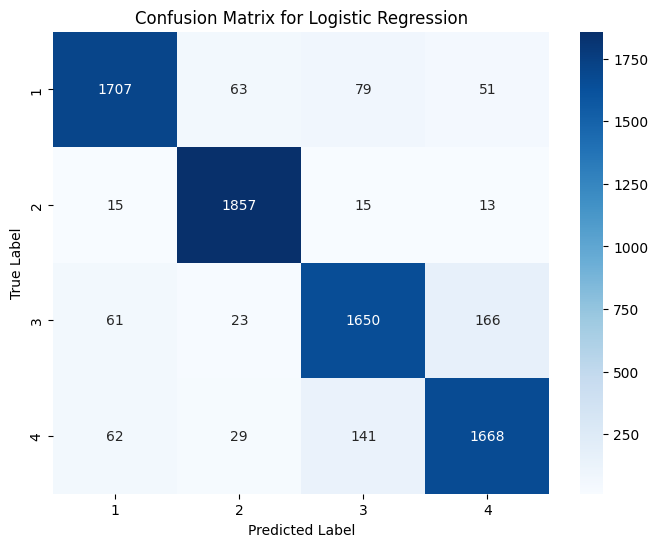

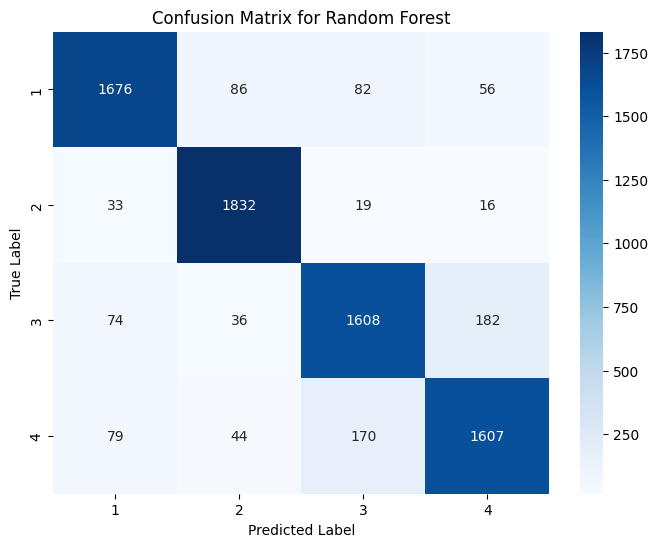

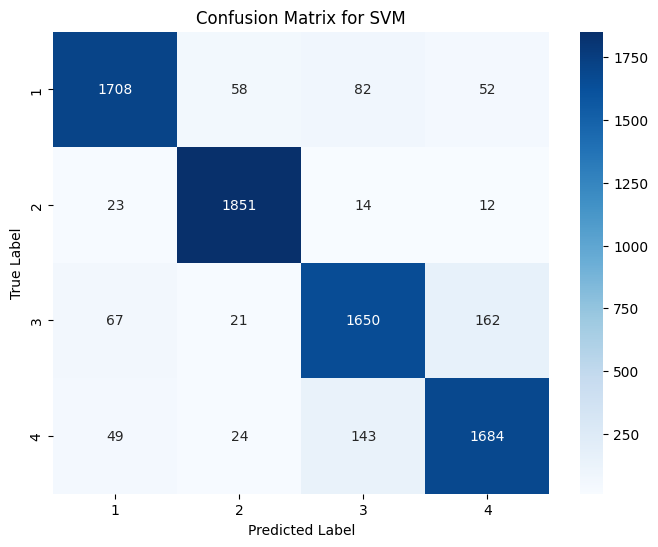

Confusion Matrices generated successfully!


In [17]:
# Function to plot Confusion Matrix for a given model
def plot_confusion_matrix(model, y_true, title):
    """
    Plot the Confusion Matrix for a trained model.

    Args:
        model: Trained model object
        y_true (array): True labels
        title (str): Title for the plot
    """
    y_pred = model.predict(classifier.X_test)  # Predict using the test data
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 5), yticklabels=range(1, 5))
    plt.title(f'Confusion Matrix for {title}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plot Confusion Matrix for each model
print("Generating Confusion Matrices...")
for name, model in classifier.models.items():
    plot_confusion_matrix(model, classifier.y_test, name)

print("Confusion Matrices generated successfully!")

/tmp/ipython-input-72804281.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', len(categories))


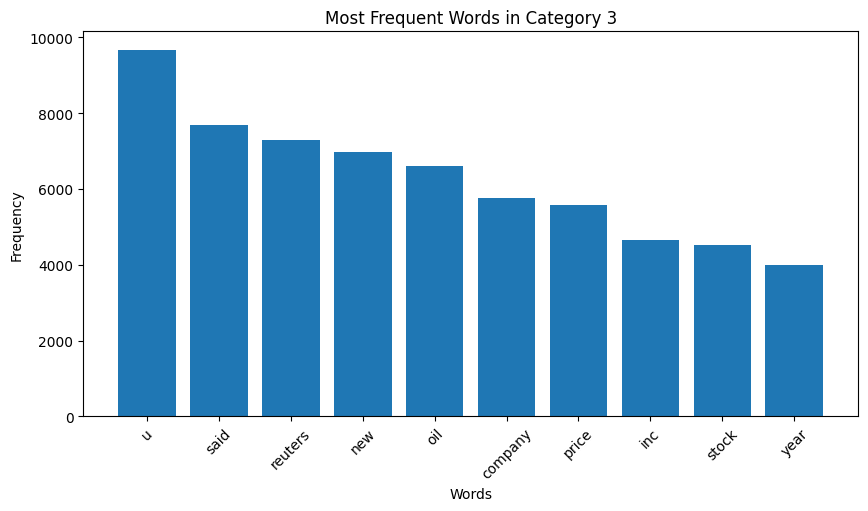

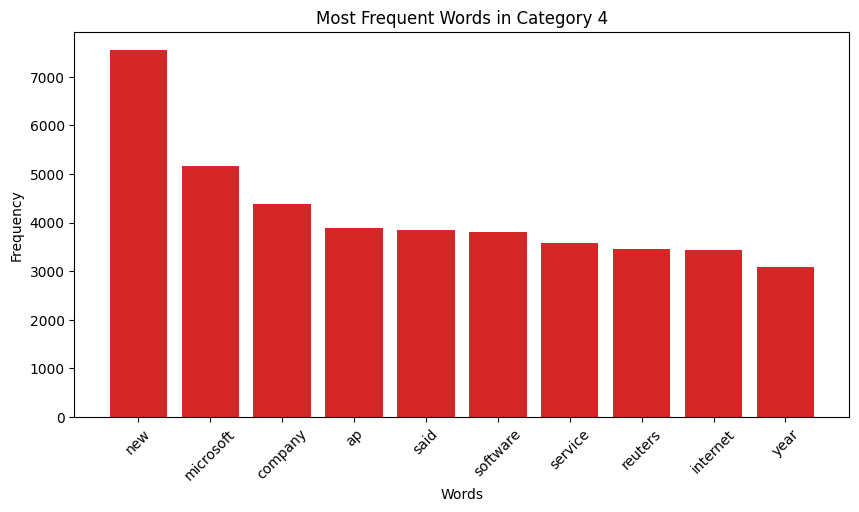

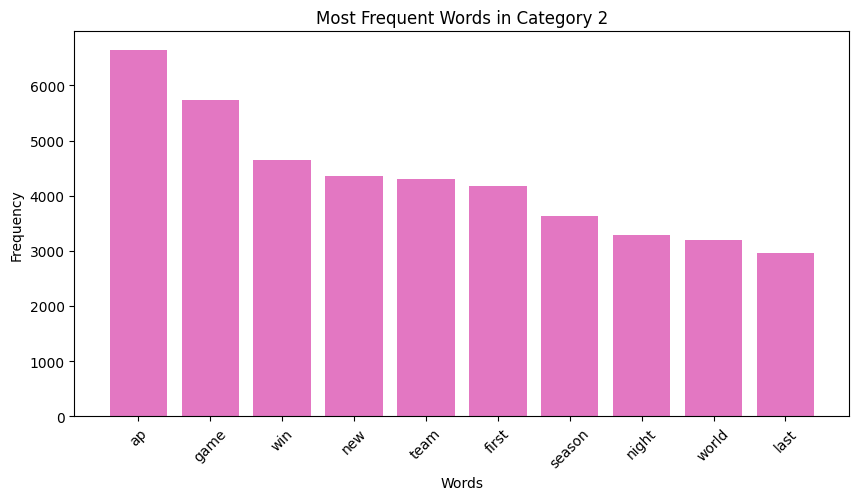

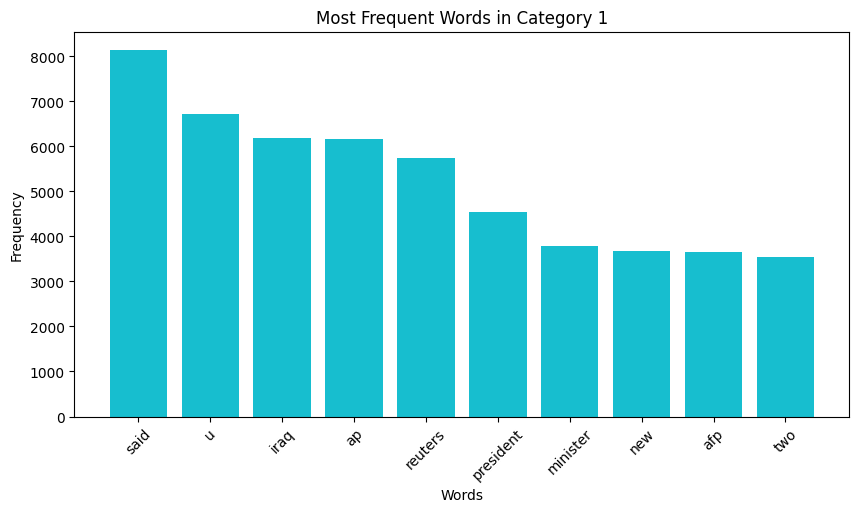

In [19]:
# Define WordFrequencyAnalyzer class for analyzing frequent words per category
class WordFrequencyAnalyzer:
    def __init__(self, data, text_column, category_column):
        """
        Initialize WordFrequencyAnalyzer with dataset and column names.

        Args:
            data (pandas.DataFrame): Input dataset
            text_column (str): Name of the text column
            category_column (str): Name of the category column
        """
        self.data = data
        self.text_column = text_column
        self.category_column = category_column

    def get_frequent_words_per_category(self, top_n=10):
        """
        Get the most frequent words for each category.

        Args:
            top_n (int): Number of top words to return

        Returns:
            dict: Dictionary of category names and their frequent words
        """
        freq_words = {}
        categories = self.data[self.category_column].unique()

        for category in categories:
            texts = self.data[self.data[self.category_column] == category][self.text_column]
            all_words = ' '.join(texts).split()
            freq_words[category] = dict(Counter(all_words).most_common(top_n))

        return freq_words

    def plot_frequent_words(self, freq_words):
        """
        Plot bar charts for frequent words per category.

        Args:
            freq_words (dict): Dictionary of category names and their frequent words
        """
        import matplotlib.cm as cm

        categories = list(freq_words.keys())
        color_map = cm.get_cmap('tab10', len(categories))

        for idx, category in enumerate(categories):
            # Sort words by frequency descending
            words_freq = sorted(freq_words[category].items(), key=lambda x: x[1], reverse=True)
            words, frequencies = zip(*words_freq)

            plt.figure(figsize=(10, 5))
            plt.bar(words, frequencies, color=color_map(idx))
            plt.title(f'Most Frequent Words in Category {category}')
            plt.xlabel('Words')
            plt.ylabel('Frequency')
            plt.xticks(rotation=45)
            plt.show()

# Instantiate WordFrequencyAnalyzer
word_analyzer = WordFrequencyAnalyzer(data, 'processed_text', 'Class Index')

# Get and plot frequent words (without saving)
freq_words = word_analyzer.get_frequent_words_per_category()
word_analyzer.plot_frequent_words(freq_words)


In [ ]:
## Bonus: Neural Network Classifier

In [3]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Define DataLoader class
class DataLoader:
    def __init__(self, train_path, test_path):
        self.train_path = train_path
        self.test_path = test_path
        self.data = None

    def load_data(self):
        train_data = pd.read_csv(self.train_path)
        test_data = pd.read_csv(self.test_path)
        train_data['split'] = 'train'
        test_data['split'] = 'test'
        self.data = pd.concat([train_data, test_data], ignore_index=True)
        self.data['combined_text'] = self.data['Title'] + ' ' + self.data['Description']
        return self.data

# Define TextPreprocessor class
class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        words = word_tokenize(text)
        words = [self.lemmatizer.lemmatize(word) for word in words if word not in self.stop_words]
        return ' '.join(words)

    def preprocess(self, texts):
        return [self.clean_text(text) for text in texts]

# Define NewsVectorizer class
class NewsVectorizer:
    def __init__(self):
        self.vectorizer = TfidfVectorizer(max_features=5000)
        self.X = None

    def vectorize(self, texts):
        self.X = self.vectorizer.fit_transform(texts)
        return self.X

# Define NeuralNetworkClassifier class
class NeuralNetworkClassifier:
    def __init__(self, X, y, data):
        self.X = X  # لا تحول إلى array هنا
        self.y = to_categorical(y - 1)  # shift labels to start from 0
        self.data = data
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.model = None

    def prepare_data(self):
        train_data = self.data[self.data['split'] == 'train']
        test_data = self.data[self.data['split'] == 'test']
        self.X_train = self.X[train_data.index].toarray()
        self.X_test = self.X[test_data.index].toarray()
        self.y_train = self.y[train_data.index]
        self.y_test = self.y[test_data.index]

    def build_model(self, input_dim):
        self.model = Sequential([
            Dense(128, activation='relu', input_shape=(input_dim,)),
            Dense(64, activation='relu'),
            Dense(self.y.shape[1], activation='softmax')
        ])
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    def train_and_evaluate(self):
        self.build_model(self.X_train.shape[1])
        self.model.fit(self.X_train, self.y_train, epochs=10, batch_size=32, verbose=1)
        _, accuracy = self.model.evaluate(self.X_test, self.y_test, verbose=0)
        print(f"\nNeural Network Accuracy: {accuracy:.2f}")
        y_pred = self.model.predict(self.X_test)
        y_pred_classes = y_pred.argmax(axis=1)
        y_test_classes = self.y_test.argmax(axis=1)
        print("Classification Report:")
        print(classification_report(y_test_classes, y_pred_classes))

# Load data
train_path = '/content/drive/My Drive/Elevvo_Pathway/Task_2/train.csv'
test_path = '/content/drive/My Drive/Elevvo_Pathway/Task_2/test.csv'
data_loader = DataLoader(train_path, test_path)
data = data_loader.load_data()

# Preprocess text
preprocessor = TextPreprocessor()
data['processed_text'] = preprocessor.preprocess(data['combined_text'])

# Vectorize text
vectorizer = NewsVectorizer()
X = vectorizer.vectorize(data['processed_text'])

# Prepare labels and run model
y = data['Class Index']
nn_classifier = NeuralNetworkClassifier(X, y, data)
nn_classifier.prepare_data()
nn_classifier.train_and_evaluate()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.8712 - loss: 0.4037
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9289 - loss: 0.2036
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9462 - loss: 0.1525
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9657 - loss: 0.1003
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9815 - loss: 0.0566
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9891 - loss: 0.0319
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9932 - loss: 0.0208
Epoch 8/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9951 - loss: 0.0142
Epoch 9/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9961 - loss: 0.0109
Epoch 10/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9965 - loss: 0.0097

Neural Network Accuracy: 0.90
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report:
              pr